# IFT 6758 - Devoir 3 

### Pt 2. Classement d'éches
**Comparaison des groupes sur/sous-représentés**

Evaluation de ce notebook :

- Graphiques pour les distributions de scores et d'écarts
- Résultats imprimés des tests de permutation
- Réponses courtes (dernière section)


In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [127]:
import chess_rating

## 1. Chargez les données

### 1.1 Lire les données XML

In [128]:
xml_path = Path("data/standard_oct22frl_xml.xml")  # shouldn't need to change this

In [129]:
# TODO: Complétez cette méthode dans chess_ratings.py
raw_df = chess_rating.parse_xml(xml_path)

In [130]:
# Vérifiez pour voir un échantillon de 5 joueurs
random.seed(0)
raw_df.sample(5)

,name,rating,sex,birthday,country,flag,title
42279,"Bistriceanu, Traian",1423,M,2004,ROU,i,None
370989,"Varaljai, Attila",2214,M,1962,HUN,i,None
131848,"Gunin, Pavel",2186,M,1986,RUS,i,None
194986,"Le Corronc, Alan",1263,M,2007,FRA,None,None
88303,"Dolmer, William",1165,M,2004,CAN,None,None


In [131]:
# Vérifiez pour voir les dtypes du dataframe brut
raw_df.dtypes

name        object
rating      object
sex         object
birthday    object
country     object
flag        object
title       object
dtype: object

In [132]:
# Voir il y a combien de dates de naissance manquantes
raw_df.birthday.isnull().sum()

8477

### 1.2 Nettoyez les données

Nous voulons que les anniversaires (année de naissance) et le score (Elo) soient convertis en nombres entiers afin que nous puissions faire des opérations numériques/logiques avec eux (par exemple, moins que, plus grand que, etc.). Complétez la méthode `clean_data()` dans `chess_rating.py`

In [133]:
# TODO: Complétez cette méthode dans chess_ratings.py
df = chess_rating.clean_data(raw_df, 2002)

In [134]:
np.random.seed(0)
df.sample(5)

,name,rating,sex,birthday,country,flag,title
206801,"Lutzen, Mads",1542,M,2000-01-01,DEN,i,None
296314,"Rieckers, Dirk",1397,M,1964-01-01,GER,i,None
120235,"Gil, Celsio",1752,M,1999-01-01,STP,i,None
147860,"Hurwitz, Ed J G",2023,M,1964-01-01,ENG,i,None
124743,"Gonzalez Gomez, Pedro Daniel",1539,M,1997-01-01,ESP,None,None


In [135]:
df.dtypes

name                object
rating               int64
sex                 object
birthday    datetime64[ns]
country             object
flag                object
title               object
dtype: object

In [136]:
df.birthday.isnull().sum()

0

## 2. Histogrammes des scores Elo

Nous voulons d'abord comparer la distribution des scores pour les joueurs masculins et féminins.
Étant donné que les données sont assez fines, nous devrons regrouper les notes.
Complétez `bin_counts()`, qui devrait gérer le binning pour les données arbitraires et le choix des bacs.
En plus de renvoyer les décomptes bruts, renvoyez également les décomptes normalisés dans la trame de données (`"count_norm"`).

### 2.1 Binning data

Voici quelques entrées de test pour vous aider à valider votre implémentation :

In [203]:
# sample inputs to help test your method
x = pd.DataFrame({'rating': [1, 2, 4, 6, 6, 7, 8, 11] })
bins = [0, 5, 10, 15]
bin_centers = [2.5, 7.5, 12.5]

# Output attendu
solution = pd.DataFrame({
    'rating': {0: 7.5, 1: 2.5, 2: 12.5},
     'count': {0: 4, 1: 3, 2: 1},
     'count_norm': {0: 0.5, 1: 0.375, 2: 0.125}
})

In [206]:
solution

,rating,count,count_norm
0,7.5,4,0.500
1,2.5,3,0.375
2,12.5,1,0.125


In [207]:
binned_output = chess_rating.bin_counts(x, bins, bin_centers)
binned_output

,rating,count,count_norm
0,7.5,4,0.500
1,2.5,3,0.375
2,12.5,1,0.125


In [208]:
solution.eq(binned_output)

,rating,count,count_norm
0,True,True,True
1,True,True,True
2,True,True,True


Utilisons cette méthode pour bin les scores M/F et les comparer.

In [209]:
# TODO: Spécifiez les bin counts 
bins = [i for i in range(1000, 2950, 50)]
bin_centers = [i for i in range(1025, 2900, 50)]

In [210]:
# Générez les données d'histogramme  
# TODO: completez chess_rating.bin_counts()
M_hist = chess_rating.bin_counts(df.query("sex=='M'"), bins=bins, bin_centers=bin_centers)
F_hist = chess_rating.bin_counts(df.query("sex=='F'"), bins=bins, bin_centers=bin_centers)

M_hist['sex'] = 'M'
F_hist['sex'] = 'F'

hist = pd.concat([M_hist, F_hist])

À l'aide des données regroupées, tracez deux graphiques linéaires des données regroupées côte à côte; l'un contenant les décomptes bruts (`"count"`), et l'autre contenant les décomptes normalisés (`"count_norm"`), et M/F doit être de deux couleurs différentes.

<Axes: xlabel='rating', ylabel='count_norm'>

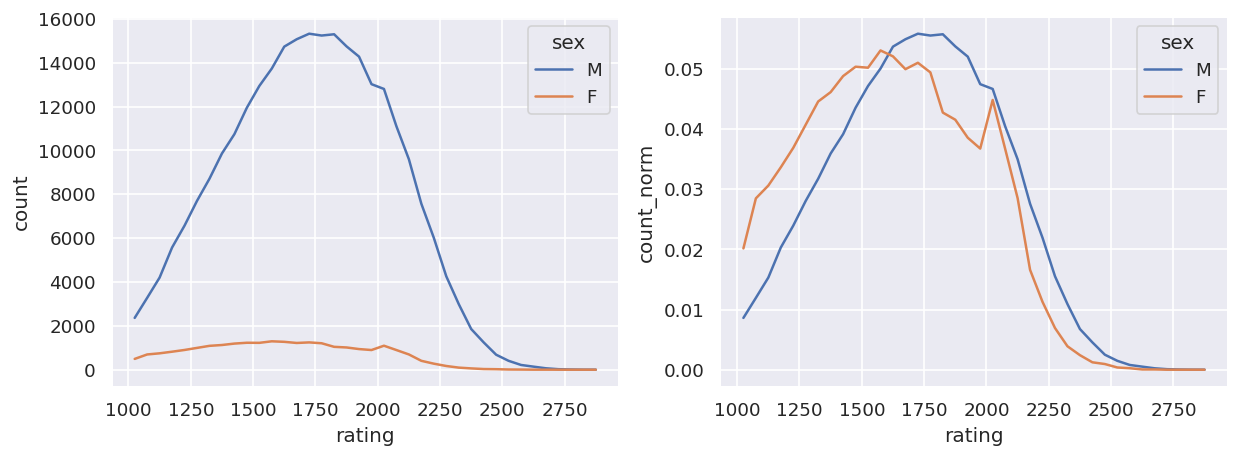

In [211]:
# Now draw the two histograms side-by-side. 
fig, ax = plt.subplots(1,2, figsize=(12, 4), dpi=120)
sns.lineplot(data=hist, x="rating", y="count", hue='sex', ax=ax[0])
sns.lineplot(data=hist, x="rating", y="count_norm", hue='sex', ax=ax[1])

## 3. Tests de Permutation

Nous allons maintenant effectuer les tests de permutation comme indiqué dans l'expérience de pensée de l'introduction.
Prenez l'ensemble de données nettoyé complet (hommes et femmes) et échantillonnez au hasard deux groupes sans remplacement (c'est-à-dire mélangez les joueurs).
La taille des groupes doit refléter la différence du monde réel que nous souhaitons étudier, c'est-à-dire la taille du groupe masculin et féminin.
Terminez `chess_rating.PermutationTests.job()`, qui implémente la partie échantillonnage de cette expérience, et renvoie la valeur maximale des groupes surreprésentés et sous-représentés respectivement.

Ensuite, complétez la méthode `chess_rating.sample_two_groups()`, qui exécute cette expérience `n_iter` fois.
Une fois terminé, exécutez cette expérience dans le bloc-notes avec au moins `n_iter=1000`.
Exécutez la cellule qui imprime la différence moyenne obtenue à partir des tests de permutation, ainsi que les différences réelles.

In [291]:
n_overrep = df.query("sex=='M'").shape[0]
n_underrep = df.query("sex=='F'").shape[0]

over, under = chess_rating.sample_two_groups(df, n_overrep, n_underrep, n_iter=1000)

100%|██████████| 1000/1000 [00:02<00:00, 337.61it/s]


In [292]:
diffs = over - under
max_M, max_F = df.query("sex=='M'").rating.max(), df.query("sex=='F'").rating.max()

In [293]:
print(f"Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:")
print(f"\n\t{diffs.mean()} (std={diffs.std().round(2)})")
print()
print("Real values:\n")
print(f"\tMax M:\t\t{max_M}")
print(f"\tMax F:\t\t{max_F}")
print(f"\tReal difference: {max_M - max_F}")

Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:

	86.687 (std=48.63)

Real values:

	Max M:		2856
	Max F:		2675
	Real difference: 181


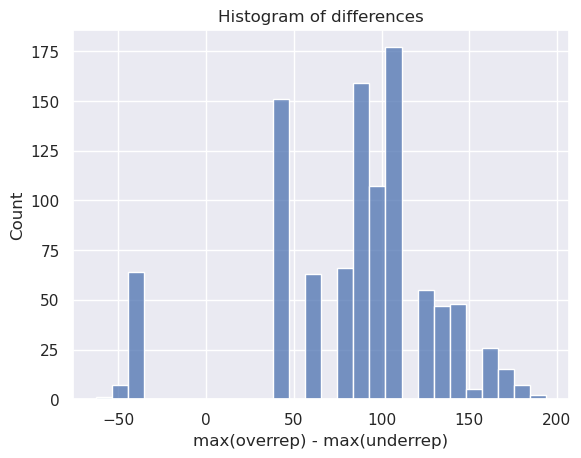

In [294]:
fig, ax = plt.subplots(1, 1, dpi=100)
sns.histplot(diffs, ax=ax).set(title="Histogram of differences", xlabel="max(overrep) - max(underrep)");

# Questions 

Donnez des réponses courtes aux questions suivantes (1-3 lignes chaques).

1. Interprétez les résultats - pouvez-vous tirer une conclusion ? Rappelez-vous que l'affirmation discutée dans l'introduction de cette question était "les hommes sont meilleurs que les femmes aux échecs parce que la plupart des meilleurs joueurs sont des hommes". (Remarque : probablement une partie de votre réponse ici sera liée à votre réponse à la question suivante.)

*Réponse:* On observe une différence moyenne des scores maximums des groupes sur/sous-représentés de 86.687 avec un écart-type de 48.63. Par ailleurs, la valeure réelle de la différence entre le score maximum des hommes et des femmes est de 181, qui est nettement supérieure à la différence moyenne obtenue. Cependant, un biais de sélection est en jeu car le groupe surreprésenté (les hommes) beaucoup plus grand que le groupe sous-représenté (femmes). Il est donc fort probable que les scores soient plus élevés en raison d'un plus grand échantillon.


2. Pensez-vous que les chiffres obtenus ici racontent toute l'histoire ? Quels pourraient être les problèmes avec l'analyse menée ici ? Les données avec lesquelles nous travaillons sont-elles biaisées d'une quelconque manière (autre qu'un biais de surreprésentation) ? L'ELO est-il une bonne mesure et peut-il être utilisé pour répondre à la question initiale ? Existe-t-il des différences dans le traitement social, culturel et systémique des hommes et des femmes qui peuvent empêcher le groupe sous-représenté d'obtenir des résultats similaires ? Rien d'autre?

*Réponse:* 
Effectivement, les chiffres ne racontent pas tout et il manque une grande partie de l'histoire. Tout d'abord, comme mentionné précédemment, les femmes sont nettement moins représentées dans les échecs. Cette faible représentation peut être significativement influencé par divers facteurs extérieurs et des biais historiques. 

Historiquement, les femmes ont souvent eu un accès restreint aux échecs, en raison des normes et attentes sociales et culturelles restrictive.
Les femmes dans les échecs fonc facent a des obstacles qui entravent leurs progressions et leurs performances. Cela inclut les stéréotypes de genre qui peuvent réduire leur confiance, le manque de modèles féminins dans les échecs de haut niveau, et un environnement qui peut parfois être moins accueillant er même hostile. 

D'autre part, plusieurs femmes de haut niveau ont reporté des expériences de discrimination et de harcèlement lors tournois d'échecs, illustrant des défis supplémentaires qu'elles peuvent rencontrer. Un exemple récent peut être trouvé ici : [Eight Women Accuse Chess Grandmaster Ramirez Of Sexual Misconduct](https://www.forbes.com/sites/anafaguy/2023/03/07/eight-women-accuse-chess-grandmaster-ramirez-of-sexual-misconduct-report-says/?sh=67ef3ba53542).

L'ELO n'est pas une mesure parfaite de la compétence aux échecs, surtout lorsqu'on considère que les femmes, étant moins nombreuses dans les échecs, ont souvent moins d'opportunités de jouer contre des adversaires du même sexe et de s'étendre en s'entraînant contre des hommes. Les compétitions sont souvent (même trop souvent) séparées entre genre! Cela pourrait limiter leur capacité à augmenter leur ELO, étant donné que le système ELO récompense ou pénalise les joueurs en fonction du classement de leurs adversaires. Les femmes sont tout aussi capable que les hommes mais leur ELO leur empechent de le prouver: [Judit Polgar qui bat Magnus Carlsen dans un match de blitz amical ;) (pas la première fois!)](https://www.youtube.com/watch?v=hvbZCRid5CY)

On espére voir une amélioration pour les femmes dans le monde des échecs. On observe de plus en plus de modèles féminins et du contenu de média qui soulèvent ces problèmes, comme dans "Queen's Gambit" ou dans le monde du streaming avec les Botez Sisters.


Le but de ces questions est de souligner que les données sont une représentation limitée du monde réel. Il est essentiel pour nous, en tant que scientifiques des données, de prendre du recul lorsque nous examinons un résultat et de réfléchir à la façon dont il est lié au monde réel, plutôt que de simplement supposer naïvement que les données et la configuration expérimentale sont bonnes, ce qui entraîne souvent des conclusions erronées/incorrectes. Il pourrait y avoir plusieurs facteurs de causalité qui expliquent une relation qui sont indépendants de l'hypothèse d'origine: utilisation de données qui ne reflètent pas vraiment l'hypothèse que vous souhaitez tester, données biaisées (y compris les groupes surreprésentés), différences systémiques réelles entre les groupes, etc.